In [26]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

In [2]:
NB_NODES = 50
DURATION = 10000   # Nb samples
REVOLUTION = 1800  # Nb samples
SAMPLE_FREQ = 0.1  # Hz, 1 sample every 10 seconds
CONNECTION_RANGE = 30000 # m

# Variables globales pour l'analyse
SAMPLE_STEP = 12
NB_REPETITIONS = 30

# Variables globales figures
TMAX = REVOLUTION/SAMPLE_FREQ
IDX = np.arange(0, TMAX, 1/SAMPLE_FREQ) # conversion en secondes

## 1. Analyse de la densité 
Script pour générer les données :
 *  Algorithmes de division (RND, MIRW, FFD) : `chap4_rmse_density_allgroups.py`
 *  Algorithmes de clustering (KMeans) : `chap4_rmse_density_allgroups_kmeans.py`

In [33]:
df_rnd = pd.read_csv('..\output\data\sat50_RMSE_RND_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_mirw = pd.read_csv('..\output\data\sat50_RMSE_MIRW_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_ffd = pd.read_csv('..\output\data\sat50_RMSE_FFD_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_kmeans = pd.read_csv('..\output\data\sat50_RMSE_KMeans_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')

df_rnd = df_rnd.groupby('Nb groups').mean()
df_mirw = df_mirw.groupby('Nb groups').mean()
df_ffd = df_ffd.groupby('Nb groups').mean()
df_kmeans = df_kmeans.groupby('Nb groups').mean()

In [7]:
df_mirw.head()

,Timestamp,RMSE AS,RMSE ACC
Nb groups,,,
1,894.0,0.000000,2.486900e-17
2,894.0,0.459302,2.021534e-02
3,894.0,0.658785,3.024299e-02
4,894.0,0.829027,3.878378e-02
5,894.0,1.008831,4.567284e-02


### 1.1 Force des sommets

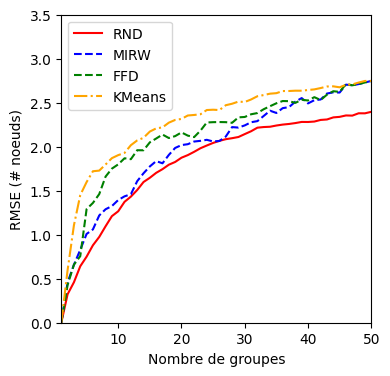

In [34]:
plt.figure(figsize=(4,4))
idx = np.arange(1, NB_NODES+1)
#idx_scat = np.arange(1, NB_NODES+1, 5)

col = 'RMSE AS' 
plt.plot(idx, df_rnd[col], '-r', label='RND')
plt.plot(idx, df_mirw[col], '--b', label='MIRW')
plt.plot(idx, df_ffd[col], '--g', label='FFD')
plt.plot(idx, df_kmeans[col], ls='-.', c='orange', label='KMeans')

plt.xlabel('Nombre de groupes')
plt.ylabel('RMSE (# noeuds)')
plt.xlim(1,50)
plt.ylim(0,3.5)
plt.legend(loc='upper left')

### 1.2 Coefficient de clustering moyen

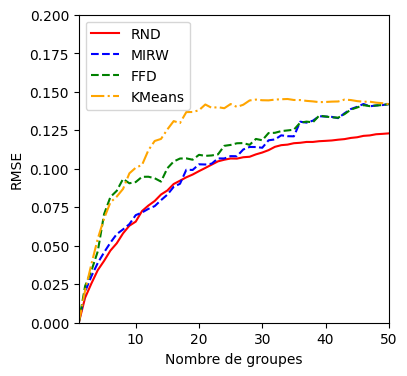

In [35]:
plt.figure(figsize=(4,4))
idx = np.arange(1, NB_NODES+1)
#idx_scat = np.arange(1, NB_NODES+1, 5)

col = 'RMSE ACC' 
plt.plot(idx, df_rnd[col], '-r', label='RND')
plt.plot(idx, df_mirw[col], '--b', label='MIRW')
plt.plot(idx, df_ffd[col], '--g', label='FFD')
plt.plot(idx, df_kmeans[col], ls='-.', c='orange', label='KMeans')

plt.xlabel('Nombre de groupes')
plt.ylabel('RMSE')
plt.xlim(1,50)
plt.ylim(0,.2)
plt.legend()

## 2. Analyse de la taille des groupes

In [24]:
PATH = '..\\..\\data\\cnes_swarm50\\track_'
NB_GROUPS = np.arange(1,NB_NODES+1)

def rmse(data, ref=None):
    """
    This function calculates the Root Mean Square Error (RMSE) between the observed distribution and a reference value.

    Parameters:
    data (list or numpy array): A list or numpy array containing the observed data points.
    ref (float, optional): A reference value to compare the observed distribution with. Defaults to the mean of the observed data.

    Returns:
    float: The RMSE value, which represents the standard deviation of the differences between the observed data and the reference value.

    Example:
    >>> data = [1, 2, 3, 4, 5]
    >>> ref = 3
    >>> rmse(data, ref)
    0.8164965809277461
    """
    if ref is None:
        ref = np.mean(data)
    errors = [(e - ref) ** 2 for e in data]
    ratio = sum(errors) / len(data)
    return np.sqrt(ratio)

In [25]:
satellites = {} # Dict(sat_id: DataFrame)
with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df = pd.read_csv(PATH+str(i)+'.csv')
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)
        
swarm_data = {} # Dict{timestamp: Swarm}
with tqdm(total = REVOLUTION, desc = 'Converting to Swarm') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
            )
        pbar.update(1)
        
neighbor_matrices = {} # Dict{timestamp: matrix}
with tqdm(total=REVOLUTION, desc='Computing neighbor matrices') as pbar:
    for t in range(REVOLUTION):
        neighbor_matrices[t] = swarm_data[t].neighbor_matrix(weighted=True)
        pbar.update(1)
        
# Création des graphes associés  
with tqdm(total=REVOLUTION, desc='Generating graphs') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t].create_graph()
        pbar.update(1)

Generating graphs: 100%|██████████| 1800/1800 [00:17<00:00, 104.98it/s]


In [27]:
# Enlever les ISL trop chers de l'essaim (ceux dont le coût est supérieur au coût du plus court chemin)
with tqdm(total=REVOLUTION, desc = 'Removing expensive edges') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t].remove_expensive_edges()
        pbar.update(1)

Removing expensive edges: 100%|██████████| 1800/1800 [06:27<00:00,  4.64it/s]


In [28]:
rmse_rnd = []
rmse_mirw = []
rmse_ffd = []
rmse_kmeans = []

swarm = swarm_data[0]

for nb in NB_GROUPS:
    ref_ns = NB_NODES/nb

    ns = []
    for rep in range(NB_REPETITIONS):
        swarm.reset_groups()
        groups = swarm.RND(n=nb, s=rep+1) # <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    rmse_rnd.append(rmse(ns, ref_ns))

    ns = []
    for rep in range(NB_REPETITIONS):
        swarm.reset_groups()
        groups = swarm.MIRW(n=nb, s=rep+1) # <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    rmse_mirw.append(rmse(ns, ref_ns))

    ns = []
    for rep in range(NB_REPETITIONS):
        swarm.reset_groups()
        groups = swarm.FFD(n=nb, s=rep+1) # <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    rmse_ffd.append(rmse(ns, ref_ns))
    
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm.reset_groups()
        kmeans = KMeans(n_clusters=nb).fit([[n.x, n.y, n.z] for n in swarm.nodes]) # <==================== ALGO CHOICE 
        groups = {}
        for i in range(nb):
            groups[i] = [node.id for node in swarm.nodes if kmeans.labels_[node.id]==i]
        ns.extend([len(group) for group in groups.values()])
    rmse_kmeans.append(rmse(ns, ref_ns))

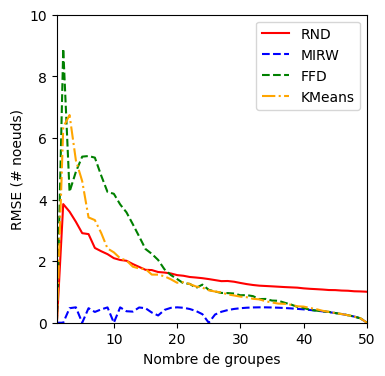

In [32]:
plt.figure(figsize=(4,4))

plt.plot(NB_GROUPS, rmse_rnd, '-r', label='RND')
plt.plot(NB_GROUPS, rmse_mirw, '--b', label='MIRW')
plt.plot(NB_GROUPS, rmse_ffd, '--g', label='FFD')
plt.plot(NB_GROUPS, rmse_kmeans, ls='-.', c='orange', label='KMeans')

plt.xlabel('Nombre de groupes')
plt.ylabel('RMSE (# noeuds)')
plt.xlim(1,50)
plt.ylim(0,10)
plt.legend()

## 3. Analyse du coût de routage
Script pour générer les données : `chap4_routingcost_allgroups.py`

In [36]:
df_rnd = pd.read_csv('..\output\data\sat50_RCOST_RND_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_mirw = pd.read_csv('..\output\data\sat50_RCOST_MIRW_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_ffd = pd.read_csv('..\output\data\sat50_RCOST_FFD_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_kmeans = pd.read_csv('..\output\data\sat50_RCOST_KMeans_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')

df_rnd = df_rnd.groupby('Nb groups').mean()
df_mirw = df_mirw.groupby('Nb groups').mean()
df_ffd = df_ffd.groupby('Nb groups').mean()
df_kmeans = df_kmeans.groupby('Nb groups').mean()

In [19]:
df_kmeans.head()

,Timestamp,Rcost
Nb groups,,
1,894.0,13004.373333
2,894.0,5800.028000
3,894.0,3886.186222
4,894.0,2829.007111
5,894.0,2138.519556


In [17]:
ref_rcost_avg = df_rnd['Rcost'].iloc[0]
print('Coût de routage moyen dans le graphe original:', int(ref_rcost_avg), 'transmissions')

Coût de routage moyen dans le graphe original: 13004 transmissions


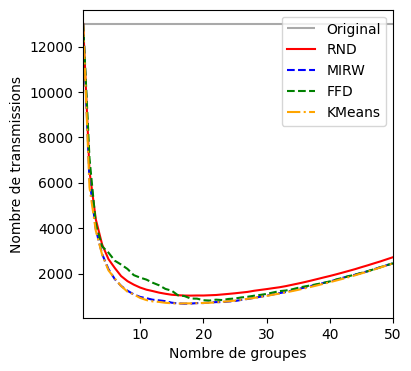

In [37]:
plt.figure(figsize=(4,4))
idx = np.arange(1, NB_NODES+1)

col = 'Rcost' 
plt.hlines(ref_rcost_avg, xmin=1, xmax=50, colors='darkgray', label='Original')
plt.plot(idx, df_rnd[col], '-r', label='RND')
plt.plot(idx, df_mirw[col], '--b', label='MIRW')
plt.plot(idx, df_ffd[col], '--g', label='FFD')
plt.plot(idx, df_kmeans[col], ls='-.', c='orange', label='KMeans')

plt.xlabel('Nombre de groupes')
plt.ylabel('Nombre de transmissions')
plt.xlim(1,50)
#plt.ylim(0,30)
plt.legend()

In [23]:
nb_groups_opt = df_mirw['Rcost'].idxmin()
rcost_min = df_mirw['Rcost'].loc[nb_groups_opt]
print('Nombre de transmissions optimal:', round(rcost_min,0), '\t obtenu pour', nb_groups_opt, 'groupes')

Nombre de transmissions optimal: 669.0 	 obtenu pour 17 groupes
